In [1]:
import tensorflow as tf

/anaconda/envs/ml_env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
import numpy as np

In [263]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split


X_old, y_old = make_moons(n_samples=100000, shuffle=True, noise=0.1, random_state=42)
y = y_old.reshape(-1, 1)


X = np.c_[np.ones(X_old.shape[0]), X_old]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

n = X.shape[1]
X_test.shape

(5000, 3)

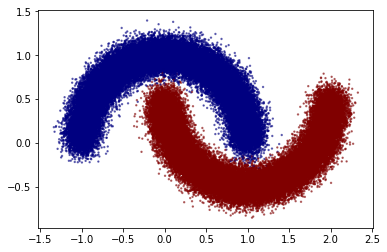

In [264]:
import matplotlib.pyplot as plt

plt.scatter(X[:,1], X[:,2], c=y_old, cmap="jet", s=2, alpha=0.5)
plt.show()

# Now we start construct the model

### Setting some basic parameters

In [5]:
learning_rate =0.1
n_epoch = 1000
n_batch = 50
batch_size = 95000/n_batch

### Defining some common functions

In [6]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [7]:
def fetch_batch_data(X, y, epoch, batch, n_batch=20, batch_size=None):
    if not batch_size:
        batch_size = X.shape[0]//n_batch
    np.random.seed(epoch * n_batch + batch)
    indicies = np.random.randint(X.shape[0], size=batch_size)
    X_batch = X[indicies]
    y_batch = y[indicies].reshape(-1, 1)
    return X_batch, y_batch

In [8]:
def get_checkpt(root_dir, prefix):
    i = 1
    while os.path.isdir(os.path.join(root_dir, "{}{}/".format(prefix, i))):
        i += 1
    sav_dir = os.path.join(root_dir, "{}{}/".format(prefix, i-1))
    if os.path.isfile(os.path.join(sav_dir, "final.ckpt.meta")) and \
            os.path.isfile(os.path.join(sav_dir, "final.ckpt.index")):
        return os.path.join(sav_dir, "final.ckpt")
    i = 1
    while os.path.isfile(os.path.join(sav_dir, "{}.ckpt.meta".format(i))) and \
        os.path.isfile(os.path.join(sav_dir, "{}.ckpt.index".format(i))):
        i += 1
    return os.path.join(sav_dir, "{}.ckpt".format(i-1))

In [32]:
X_batch, y_batch = fetch_batch_data(X_train, y_train, 1, 1, n_batch=n_batch)
y_batch.shape

(1696, 1)

# --------------------------------------------------------------------------------------
### Construct Graph_1 for training
1.logistic regression

In [ ]:
reset_graph(np.random.randint(1000))

#### "The fail way?"

In [ ]:
# def forward_prop(X, reuse=False):
#     with tf.variable_scope("forward_prop", reuse=reuse):
#         w = tf.get_variable( name="weight", 
#                             initializer=tf.random_uniform([n, 1]))
#         b = tf.get_variable( name="bias", 
#                             initializer=tf.constant_initializer(0.0))

#         z = tf.matmul(X, w) + b
#         y_pred = tf.sigmoid(z)
        
#         return y_pred

# def calc_loss(y, y_pred, reuse=False):
#     with tf.variable_scope("calc_loss", reuse=reuse):
#         loss = -tf_y * tf.log(y_pred) - (1-y) * tf.log(1-y_pred)
#         return loss

# optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)    

# def back_prop(loss, reuse=False):
#     with tf.variable_scope("back_prop", reuse=reuse):
#         train_op = optimizer.minimize(loss)

#### First construct a very simple graph

In [116]:
tf_X = tf.placeholder(dtype=tf.float64, shape=(None, n), name="X")
tf_y = tf.placeholder(dtype=tf.float64, shape=(None, 1), name="y")

        
w = tf.Variable(tf.random_uniform([n, 1], dtype=tf.float64), name="weight", dtype=tf.float64)

z = tf.matmul(tf_X, w)
y_pred = tf.sigmoid(z)

loss = tf.reduce_mean(-tf_y * tf.log(y_pred) - (1-tf_y) * tf.log(1-y_pred))

optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)    
training_op = optimizer.minimize(loss)

initializer = tf.global_variables_initializer()

#### Now execute the graph

In [118]:
with tf.Session() as sess:
    sess.run(initializer)
    for epoch in range(n_epoch):
        for batch in range(n_batch):
            X_batch, y_batch = fetch_batch_data(X_train, y_train, epoch, batch, n_batch=n_batch)
            sess.run(training_op, feed_dict={tf_X:X_batch, tf_y:y_batch})
        if not epoch % 50:
            print("epoch:{:<3} loss: {:<3.4f}".format(epoch, loss.eval(feed_dict={tf_X:X_batch, tf_y:y_batch})))

epoch:0   loss: 0.5487
epoch:50  loss: 0.3440
epoch:100 loss: 0.3189
epoch:150 loss: 0.3260
epoch:200 loss: 0.3227
epoch:250 loss: 0.3570
epoch:300 loss: 0.3290
epoch:350 loss: 0.3252
epoch:400 loss: 0.3435
epoch:450 loss: 0.3240
epoch:500 loss: 0.3391
epoch:550 loss: 0.3532
epoch:600 loss: 0.3354
epoch:650 loss: 0.3137
epoch:700 loss: 0.3379
epoch:750 loss: 0.3234
epoch:800 loss: 0.3332
epoch:850 loss: 0.3152
epoch:900 loss: 0.3206
epoch:950 loss: 0.3082


# --------------------------------------------------------------------------------------
### Construct Graph_2 for training

1.Logistic regression
2.Save checkpoints

In [113]:
reset_graph(np.random.randint(1000))

#### First construct a very simple graph

In [116]:
tf_X = tf.placeholder(dtype=tf.float64, shape=(None, n), name="X")
tf_y = tf.placeholder(dtype=tf.float64, shape=(None, 1), name="y")

        
w = tf.Variable(tf.random_uniform([n, 1], dtype=tf.float64), name="weight", dtype=tf.float64)

z = tf.matmul(tf_X, w)
y_pred = tf.sigmoid(z)

loss = tf.reduce_mean(-tf_y * tf.log(y_pred) - (1-tf_y) * tf.log(1-y_pred))

optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)    
training_op = optimizer.minimize(loss)

initializer = tf.global_variables_initializer()

#### Now adding saving elements

The saving elements works as follows:
<ol>
<li>Check if dir i existed</li>
<li>Increment i and check again</li>
<li>Till it found the first available slot for saving</li>
</ol>

In [148]:
import os

saving_root = "temp/"
# saver = tf.train.Saver()
os.path.join(saving_root, "q12_"+str(i)+"/")

'temp/q12_1/'

#### Now execute the graph

In [161]:
def run_session(X_train, y_train, n_epoch, n_batch, saving_root, restore=False, save_file=None, saver=None):
    if not saver:
        saver = tf.train.Saver()
    
    with tf.Session() as sess:
        i = 1
        sess.run(initializer)
        if restore and save_file:
            saver.restore(sess, save_file)
        while os.path.isdir(os.path.join(saving_root, "q12_"+str(i)+"/")):
            i += 1
        saving_path = os.path.join(saving_root, "q12_"+str(i)+"/")
        print(saving_path)
        os.makedirs(saving_path)
        for epoch in range(n_epoch):
            for batch in range(n_batch):
                X_batch, y_batch = fetch_batch_data(X_train, y_train, epoch, batch, n_batch=n_batch)
                sess.run(training_op, feed_dict={tf_X:X_batch, tf_y:y_batch})
            if not epoch % 50:
                saver.save(sess, os.path.join(saving_path, str(epoch+1)+".ckpt"))
                print("epoch:{:<3} loss: {:<3.4f}".format(epoch, loss.eval(feed_dict={tf_X:X_batch, tf_y:y_batch})))
        saver.save(sess, os.path.join(saving_path, "final.ckpt"))

In [162]:
run_session(X_train, y_train, n_epoch, n_batch, saving_root)

temp/q12_9/
epoch:0   loss: 0.5487
epoch:50  loss: 0.3440
epoch:100 loss: 0.3189
epoch:150 loss: 0.3260
epoch:200 loss: 0.3227
epoch:250 loss: 0.3570
epoch:300 loss: 0.3290
epoch:350 loss: 0.3252
epoch:400 loss: 0.3435
epoch:450 loss: 0.3240
epoch:500 loss: 0.3391
epoch:550 loss: 0.3532
epoch:600 loss: 0.3354
epoch:650 loss: 0.3137
epoch:700 loss: 0.3379
epoch:750 loss: 0.3234
epoch:800 loss: 0.3332
epoch:850 loss: 0.3152
epoch:900 loss: 0.3206
epoch:950 loss: 0.3082


In [163]:
run_session(X_train, y_train, n_epoch, n_batch, saving_root, True, 'temp/q12_9/final.ckpt')

INFO:tensorflow:Restoring parameters from temp/q12_9/final.ckpt
temp/q12_10/
epoch:0   loss: 0.3231
epoch:50  loss: 0.3441
epoch:100 loss: 0.3189
epoch:150 loss: 0.3260
epoch:200 loss: 0.3227
epoch:250 loss: 0.3570
epoch:300 loss: 0.3290
epoch:350 loss: 0.3252
epoch:400 loss: 0.3435
epoch:450 loss: 0.3240
epoch:500 loss: 0.3391
epoch:550 loss: 0.3532
epoch:600 loss: 0.3354
epoch:650 loss: 0.3137
epoch:700 loss: 0.3379
epoch:750 loss: 0.3234
epoch:800 loss: 0.3332
epoch:850 loss: 0.3152
epoch:900 loss: 0.3206
epoch:950 loss: 0.3082


# --------------------------------------------------------------------------------------
### Construct Graph_3 for training
<pre>
1.Logistic regression
2.Save/Restore checkpoints
3.Adding Scope to the project
</pre>

In [199]:
reset_graph(np.random.randint(1000))

### First construction phase with scoped graph

In [200]:
def logistic_regression(X, y, learning_rate=0.1):
    with tf.name_scope("model"):
        theta = tf.Variable(tf.random_uniform([n, 1], dtype=tf.float64), name="weight", dtype=tf.float64)

        logits = tf.matmul(X, theta)
        y_proba = tf.sigmoid(logits)
    with tf.name_scope("train"):
        loss = tf.losses.log_loss(y, y_proba)

        optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)    
        training_op = optimizer.minimize(loss)

    with tf.name_scope("init"):
        initializer = tf.global_variables_initializer()
        
    with tf.name_scope("save"):
        saver = tf.train.Saver()
        
    return theta, logits, y_proba, loss, training_op, initializer, saver

In [201]:
tf_X = tf.placeholder(dtype=tf.float64, shape=(None, n), name="X")
tf_y = tf.placeholder(dtype=tf.float64, shape=(None, 1), name="y")

In [202]:
tensor = dict(zip(["theta", "logits", "y_proba", "loss", "training_op", "initializer", "saver"], 
         logistic_regression(tf_X, tf_y)))
tensor["X"], tensor["y"] = tf_X, tf_y

#### Now adding other saving elements

The saving elements works as follows:
<ol>
<li>Check if dir i existed</li>
<li>Increment i and check again</li>
<li>Till it found the first available slot for saving</li>
</ol>

In [203]:
import os

saving_root = "temp/"
# saver = tf.train.Saver()
os.path.join(saving_root, "q12_"+str(i)+"/")

'temp/q12_1/'

### Make Execution Phase function

In [223]:
def run_session(X_train, y_train, n_epoch, n_batch, saving_root, tensor, restore=False, save_file=None):
    theta, logits, y_proba, loss, training_op, initializer, saver, X, y =\
        tensor["theta"], tensor["logits"], tensor["y_proba"], tensor["loss"], tensor["training_op"], \
        tensor["initializer"], tensor["saver"], tensor["X"], tensor["y"]
    with tf.Session() as sess:
        i = 1
        sess.run(initializer)
        if restore and save_file:
            saver.restore(sess, save_file)
        while os.path.isdir(os.path.join(saving_root, "q12_"+str(i)+"/")):
            i += 1
        saving_path = os.path.join(saving_root, "q12_"+str(i)+"/")
        print("Saving the session in: {}".format(saving_path))
        os.makedirs(saving_path)
        for epoch in range(1,n_epoch+1):
            for batch in range(n_batch):
                X_batch, y_batch = fetch_batch_data(X_train, y_train, epoch, batch, n_batch=n_batch)
                sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
            if not epoch % 50:
                ind = epoch // 50 if epoch != n_epoch else "final"
                saver.save(sess, os.path.join(saving_path, "{}.ckpt".format(ind)))
                print("Ind:{:<3} epoch:{:<4} loss: {:<3.4f}".
                      format(str(ind), epoch, loss.eval(feed_dict={X:X_batch, y:y_batch})))

### Now execute

A run with save

In [230]:
run_session(X_train, y_train, n_epoch, n_batch, saving_root, tensor)

Saving the session in: temp/q12_6/
Ind:1   epoch:50   loss: 0.3440
Ind:2   epoch:100  loss: 0.3189
Ind:3   epoch:150  loss: 0.3260


KeyboardInterrupt: 

A run with last save to test check point


<strong>edit: not quite sure what happened to fail this part, it works for the first time use it. But the second time the file will disappear</strong>

In [231]:
check_pt = get_checkpt(saving_root, "q12_")
run_session(X_train, y_train, n_epoch, n_batch, saving_root, tensor, True, check_pt)

INFO:tensorflow:Restoring parameters from temp/q12_6/3.ckpt
Saving the session in: temp/q12_7/
Ind:1   epoch:50   loss: 0.3441
Ind:2   epoch:100  loss: 0.3189
Ind:3   epoch:150  loss: 0.3260
Ind:4   epoch:200  loss: 0.3227
Ind:5   epoch:250  loss: 0.3570
Ind:6   epoch:300  loss: 0.3290
Ind:7   epoch:350  loss: 0.3252


KeyboardInterrupt: 

# --------------------------------------------------------------------------------------
### Construct Graph_4 for training
<pre>
1.Logistic regression
2.Save/Restore checkpoints
3.Adding Scope to the project
4.Adding summaries for log loss, <del>recall and precision</del>
</pre>

### First construction phase with scoped graph

In [12]:
def logistic_regression(X, y, logdir, graph, learning_rate=0.1):
    with graph.as_default():
        with tf.name_scope("model"):
            theta = tf.Variable(tf.random_uniform([n, 1], dtype=tf.float64), name="weight", dtype=tf.float64)

            logits = tf.matmul(X, theta)
            y_proba = tf.sigmoid(logits)
        with tf.name_scope("train"):
            loss = tf.losses.log_loss(y, y_proba)
            precision = tf.metrics.precision(y, y_proba)
            recall = tf.metrics.recall(y, y_proba)

            optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)    
            training_op = optimizer.minimize(loss)

        with tf.name_scope("init"):
            initializer = tf.global_variables_initializer()

        with tf.name_scope("save"):
            saver = tf.train.Saver()

        with tf.name_scope("log"):
            loss_summary = tf.summary.scalar("loss", loss)
            precision_summary = tf.summary.scalar("precision", precision)
            recall_summary = tf.summary.scalar("recall", recall)
            print(tf.get_default_graph())
            file_writer = tf.summary.FileWriter(logdir, graph)
        
        
    return theta, logits, y_proba, loss, loss_summary, precision, precision_summary, recall, recall_summary,\
            training_op, initializer, saver, file_writer, graph

### Reset the graph before running

In [13]:
reset_graph(np.random.randint(1000))

AttributeError: module 'tensorflow' has no attribute 'reset_default_graph'

In [14]:
graph_4 = tf.get_default_graph()
tf_X = tf.placeholder(dtype=tf.float64, shape=(None, n), name="X")
tf_y = tf.placeholder(dtype=tf.float64, shape=(None, 1), name="y")

AttributeError: module 'tensorflow' has no attribute 'get_default_graph'

#### Now add saving elements

The saving elements works as follows:
<ol>
<li>Check if dir i existed</li>
<li>Increment i and check again</li>
<li>Till it found the first available slot for saving</li>
</ol>

In [398]:
import os

saving_root = "temp/"
i=1
os.path.join(saving_root, "{}{}/".format("q12_", i))

'temp/q12_1/'

#### Now add summary elements

In [399]:
from datetime import datetime
logging_root = "log"

### Build the graph

In [404]:
time_now = datetime.now().strftime("%Y%m%d%H%M%S")
logdir = os.path.join(logging_root, "{}-run-{}/".format("q12", time_now))
if not os.path.isdir(logdir):
    os.makedirs(logdir)
tensor = dict(zip(["theta", "logits", "y_proba", "loss", "loss_summary", "precision", "precision_summary", 
                   "recall", "recall_summary", "training_op", "initializer", "saver", "file_writer", "graph"], 
         logistic_regression(tf_X, tf_y, logdir, graph_4, learning_rate=0.05)))
tensor["X"], tensor["y"] = tf_X, tf_y

In [405]:
tf.get_default_graph()

### Make Execution Phase function

In [406]:
def run_session(X_train, y_train, n_epoch, n_batch, saving_root, 
                tensor, restore=False, save_file=None, n_save=50):
    theta, logits, y_proba, loss, loss_summary, precision, precision_summary, \
        recall, recall_summary, training_op, initializer, saver, file_writer, X, y =\
            tensor["theta"], tensor["logits"], tensor["y_proba"], tensor["loss"], \
                tensor["loss_summary"], tensor["precision"], tensor["precision_summary"], \
                    tensor["recall"], tensor["recall_summary"] ,tensor["training_op"], \
                        tensor["initializer"], tensor["saver"], tensor["file_writer"], tensor["X"], tensor["y"]
    with tf.Session() as sess:
        i = 1
        sess.run(initializer)
        if restore and save_file:
            saver.restore(sess, save_file)
        while os.path.isdir(os.path.join(saving_root, "q12_"+str(i)+"/")):
            i += 1
        saving_path = os.path.join(saving_root, "q12_"+str(i)+"/")
        print("Saving the session in: {}".format(saving_path))
        os.makedirs(saving_path)
        file_writer.add_graph(tf.get_default_graph())
        
        for epoch in range(1,n_epoch+1):
            for batch in range(n_batch):
                X_batch, y_batch = fetch_batch_data(X_train, y_train, epoch, batch, n_batch=n_batch)
                if not (batch % (n_batch // 3)):
#                   the log for precision and recall isnt added yet
                    loss_log = loss_summary.eval(feed_dict={X:X_batch, y:y_batch})
                    file_writer.add_summary(loss_log, (epoch-1) * n_batch + batch)
                sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
            if not epoch % n_save:
                ind = epoch // n_save if epoch != n_epoch else "final"
                saver.save(sess, os.path.join(saving_path, "{}.ckpt".format(ind)))
                print("Ind:{:<3} epoch:{:<4} loss: {:<3.4f}".
                      format(str(ind), epoch, loss.eval(feed_dict={X:X_train, y:y_train})))
        file_writer.close()

### Now execute

A run with save

In [407]:
run_session(X_train, y_train, n_epoch, n_batch, saving_root, tensor, n_save=20)

Saving the session in: temp/q12_9/
Ind:1   epoch:20   loss: 0.3427
Ind:2   epoch:40   loss: 0.3349
Ind:3   epoch:60   loss: 0.3335
Ind:4   epoch:80   loss: 0.3332
Ind:5   epoch:100  loss: 0.3332
Ind:6   epoch:120  loss: 0.3332
Ind:7   epoch:140  loss: 0.3332
Ind:8   epoch:160  loss: 0.3331
Ind:9   epoch:180  loss: 0.3331
Ind:10  epoch:200  loss: 0.3332
Ind:11  epoch:220  loss: 0.3332
Ind:12  epoch:240  loss: 0.3332
Ind:13  epoch:260  loss: 0.3331
Ind:14  epoch:280  loss: 0.3332
Ind:15  epoch:300  loss: 0.3331
Ind:16  epoch:320  loss: 0.3332
Ind:17  epoch:340  loss: 0.3332
Ind:18  epoch:360  loss: 0.3332
Ind:19  epoch:380  loss: 0.3332
Ind:20  epoch:400  loss: 0.3331
Ind:21  epoch:420  loss: 0.3332
Ind:22  epoch:440  loss: 0.3331
Ind:23  epoch:460  loss: 0.3332
Ind:24  epoch:480  loss: 0.3331
Ind:25  epoch:500  loss: 0.3331
Ind:26  epoch:520  loss: 0.3332
Ind:27  epoch:540  loss: 0.3332
Ind:28  epoch:560  loss: 0.3332
Ind:29  epoch:580  loss: 0.3331
Ind:30  epoch:600  loss: 0.3331
Ind:3

A run with last save to test check point


<strong>edit: not quite sure what happened to fail this part, it works for the first time use it. But the second time the file will disappear</strong>

In [ ]:
logdir = os.path.join(logging_root, "{}-run-{}/".format("q12", time_now))
if not os.path.isdir(logdir):
    os.makedirs(logdir)
tensor = dict(zip(["theta", "logits", "y_proba", "loss", "loss_summary", "precision", "precision_summary", 
                   "recall", "recall_summary", "training_op", "initializer", "saver", "file_writer"], 
         logistic_regression(tf_X, tf_y, logdir, learning_rate=0.05)))
tensor["X"], tensor["y"] = tf_X, tf_y

In [320]:
check_pt = get_checkpt(saving_root, "q12_")
run_session(X_train, y_train, n_epoch, n_batch, saving_root, tensor, True, check_pt, n_save=20)

INFO:tensorflow:Restoring parameters from temp/q12_1/final.ckpt
Saving the session in: temp/q12_2/
Ind:1   epoch:20   loss: 0.3332
Ind:2   epoch:40   loss: 0.3331
Ind:3   epoch:60   loss: 0.3331
Ind:4   epoch:80   loss: 0.3332
Ind:5   epoch:100  loss: 0.3332
Ind:6   epoch:120  loss: 0.3331
Ind:7   epoch:140  loss: 0.3332
Ind:8   epoch:160  loss: 0.3332
Ind:9   epoch:180  loss: 0.3332
Ind:10  epoch:200  loss: 0.3332
Ind:11  epoch:220  loss: 0.3332
Ind:12  epoch:240  loss: 0.3332
Ind:13  epoch:260  loss: 0.3331
Ind:14  epoch:280  loss: 0.3332
Ind:15  epoch:300  loss: 0.3331
Ind:16  epoch:320  loss: 0.3332
Ind:17  epoch:340  loss: 0.3332
Ind:18  epoch:360  loss: 0.3332
Ind:19  epoch:380  loss: 0.3332
Ind:20  epoch:400  loss: 0.3331
Ind:21  epoch:420  loss: 0.3332
Ind:22  epoch:440  loss: 0.3331
Ind:23  epoch:460  loss: 0.3332
Ind:24  epoch:480  loss: 0.3331
Ind:25  epoch:500  loss: 0.3331
Ind:26  epoch:520  loss: 0.3332
Ind:27  epoch:540  loss: 0.3332
Ind:28  epoch:560  loss: 0.3332
Ind:2

# --------------------------------------------------------------------------------------
### Construct Graph_5 for training
<pre>
1.Logistic regression
2.Save/Restore checkpoints
3.Adding Scope to the project
4.Adding summaries for log loss, <del>recall and precision</del>
5.Changing the learning_rate and n_batch and observe the change in board
</pre>

### First construction phase with scoped graph

In [9]:
def logistic_regression(X, y, logdir, graph, learning_rate=0.1):
    with graph.as_default():
        with tf.name_scope("model"):
            theta = tf.Variable(tf.random_uniform([n, 1], dtype=tf.float64), name="weight", dtype=tf.float64)

            logits = tf.matmul(X, theta)
            y_proba = tf.sigmoid(logits)
        with tf.name_scope("train"):
            loss = tf.losses.log_loss(y, y_proba)
            precision = tf.metrics.precision(y, y_proba)
            recall = tf.metrics.recall(y, y_proba)

            optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)    
            training_op = optimizer.minimize(loss)

        with tf.name_scope("init"):
            initializer = tf.global_variables_initializer()

        with tf.name_scope("save"):
            saver = tf.train.Saver()

        with tf.name_scope("log"):
            loss_summary = tf.summary.scalar("loss", loss)
            precision_summary = tf.summary.scalar("precision", precision)
            recall_summary = tf.summary.scalar("recall", recall)
            print(tf.get_default_graph())
        file_writer = tf.summary.FileWriter(logdir, graph)
        
        
    return theta, logits, y_proba, loss, loss_summary, precision, precision_summary, recall, recall_summary,\
            training_op, initializer, saver, file_writer, graph

### Reset the graph before running

In [10]:
reset_graph(np.random.randint(1000))

In [11]:
graph_4 = tf.get_default_graph()
tf_X = tf.placeholder(dtype=tf.float64, shape=(None, n), name="X")
tf_y = tf.placeholder(dtype=tf.float64, shape=(None, 1), name="y")

#### Now add saving elements

The saving elements works as follows:
<ol>
<li>Check if dir i existed</li>
<li>Increment i and check again</li>
<li>Till it found the first available slot for saving</li>
</ol>

In [12]:
import os

saving_root = "temp/"
i=1
os.path.join(saving_root, "{}{}/".format("q12_", i))

'temp/q12_1/'

#### Now add summary elements

In [13]:
from datetime import datetime
logging_root = "log"

### Build the graph

time_now = datetime.now().strftime("%Y%m%d%H%M%S")
logdir = os.path.join(logging_root, "{}-run-{}/".format("q12", time_now))
if not os.path.isdir(logdir):
    os.makedirs(logdir)
tensor = dict(zip(["theta", "logits", "y_proba", "loss", "loss_summary", "precision", "precision_summary", 
                   "recall", "recall_summary", "training_op", "initializer", "saver", "file_writer", "graph"], 
         logistic_regression(tf_X, tf_y, logdir, graph_4, learning_rate=0.05)))
tensor["X"], tensor["y"] = tf_X, tf_y

tf.get_default_graph()

### Make Execution Phase function

In [14]:
def train_model(X_train, y_train, n_epoch, n_batch, saving_root, 
                tensor, restore=False, save_file=None, n_save=50):
    theta, logits, y_proba, loss, loss_summary, precision, precision_summary, \
        recall, recall_summary, training_op, initializer, saver, file_writer, X, y =\
            tensor["theta"], tensor["logits"], tensor["y_proba"], tensor["loss"], \
                tensor["loss_summary"], tensor["precision"], tensor["precision_summary"], \
                    tensor["recall"], tensor["recall_summary"] ,tensor["training_op"], \
                        tensor["initializer"], tensor["saver"], tensor["file_writer"], tensor["X"], tensor["y"]
    with tf.Session() as sess:
        i = 1
        sess.run(initializer)
        if restore and save_file:
            saver.restore(sess, save_file)
        while os.path.isdir(os.path.join(saving_root, "q12_"+str(i)+"/")):
            i += 1
        saving_path = os.path.join(saving_root, "q12_"+str(i)+"/")
        print("Saving the session in: {}".format(saving_path))
        os.makedirs(saving_path)
        
        for epoch in range(1,n_epoch+1):
            for batch in range(n_batch):
                X_batch, y_batch = fetch_batch_data(X_train, y_train, epoch, batch, n_batch=n_batch)
                if not (batch % (n_batch // 3)):
#                   the log for precision and recall isnt added yet
                    loss_log = loss_summary.eval(feed_dict={X:X_batch, y:y_batch})
                    file_writer.add_summary(loss_log, (epoch-1) * n_batch + batch)
                sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
            if not epoch % n_save:
                ind = epoch // n_save if epoch != n_epoch else "final"
                saver.save(sess, os.path.join(saving_path, "{}.ckpt".format(ind)))
                print("Ind:{:<3} epoch:{:<4} loss: {:<3.4f}".
                      format(str(ind), epoch, loss.eval(feed_dict={X:X_train, y:y_train})))
        file_writer.close()
        return theta.eval()

### Now execute

A series of runs with different learning rate and n_batch(with less n_epoch to speed up the training)

In [15]:
reset_graph()
graphs = {}
thetas = {}
n_epoch = 300



dist_expon = np.random.exponential(0.5, 5)
learning_rates = dist_expon/np.max(dist_expon)/10


all_n_batch = np.abs(np.random.normal(50, 25, 10).astype(int))


for i in range(1):
    for j in range(1):
        graph = graphs["{}-{}".format(i,j)] = tf.Graph()
        with graph.as_default():
        
            tf_X = tf.placeholder(dtype=tf.float64, shape=(None, n), name="X")
            tf_y = tf.placeholder(dtype=tf.float64, shape=(None, 1), name="y")

            learning_rate = learning_rates[i]
            n_batch = all_n_batch[j]
            batch_size = 95000/n_batch

            time_now = datetime.now().strftime("%Y%m%d%H%M%S")
            logdir = os.path.join(logging_root, "{}-run-{}/".format("q12", time_now))


            if not os.path.isdir(logdir):
                os.makedirs(logdir)

            tensor = dict(zip(["theta", "logits", "y_proba", "loss", 
                               "loss_summary", "precision", "precision_summary", 
                               "recall", "recall_summary", "training_op", 
                               "initializer", "saver", "file_writer"], 
                                 logistic_regression(tf_X, tf_y, logdir, graph, learning_rate=0.05)))
            tensor["X"], tensor["y"] = tf_X, tf_y

            thetas["{}-{}".format(i,j)] = train_model(X_train, y_train, n_epoch, 
                                                      n_batch, saving_root, tensor, n_save=20)

Saving the session in: temp/q12_8/
Ind:1   epoch:20   loss: 0.3415
Ind:2   epoch:40   loss: 0.3349
Ind:3   epoch:60   loss: 0.3339
Ind:4   epoch:80   loss: 0.3338
Ind:5   epoch:100  loss: 0.3337
Ind:6   epoch:120  loss: 0.3337
Ind:7   epoch:140  loss: 0.3337
Ind:8   epoch:160  loss: 0.3337
Ind:9   epoch:180  loss: 0.3337
Ind:10  epoch:200  loss: 0.3337
Ind:11  epoch:220  loss: 0.3337
Ind:12  epoch:240  loss: 0.3337
Ind:13  epoch:260  loss: 0.3337
Ind:14  epoch:280  loss: 0.3337
Ind:final epoch:300  loss: 0.3337


# --------------------------------------------------------------------------------------
### Construct Graph_5 for training
<pre>
1.Logistic regression
2.Save/Restore checkpoints
3.Adding Scope to the project
4.Adding summaries for log loss, recall and precision
5.Changing the learning_rate and n_batch and observe the change in board
6.Twicking input to fit complex model
</pre>
# finally no bug!(possiblily)

### twicks inputs

In [266]:
from sklearn.preprocessing import PolynomialFeatures

pf_convert = PolynomialFeatures(degree=3)
X_twicked = pf_convert.fit_transform(X_old)
X_train_twicked, X_test_twicked, y_train, y_test = train_test_split(X_twicked, y, test_size=0.05)
n = X_train_twicked.shape[1]

### First construction phase with scoped graph

In [267]:
def logistic_regression(X, y, logdir, graph, learning_rate=0.1):
    with graph.as_default():
        with tf.name_scope("model"):
            theta = tf.Variable(tf.random_uniform([n, 1], dtype=tf.float64), name="weight", dtype=tf.float64)

            logits = tf.matmul(X, theta)
            y_proba = tf.sigmoid(logits)
            y_pred = tf.greater(y_proba, 0.5, name="y_pred")
        with tf.name_scope("train"):
            loss = tf.losses.log_loss(y, y_proba)
            precision, precision_op = tf.metrics.precision(tf.reshape(y,[-1]), y_pred)
            recall, recall_op = tf.metrics.recall(tf.reshape(y,[-1]), y_pred)

            optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)    
            training_op = optimizer.minimize(loss)

        with tf.name_scope("init"):
            global_initializer = tf.global_variables_initializer()
            local_initializer = tf.local_variables_initializer()

        with tf.name_scope("save"):
            saver = tf.train.Saver()

        with tf.name_scope("log"):
            loss_summary = tf.summary.scalar("loss", loss)
            precision_summary = tf.summary.scalar("precision", precision_op)
            recall_summary = tf.summary.scalar("recall", recall_op)
            print(tf.get_default_graph())
            file_writer = tf.summary.FileWriter(logdir, graph)
        
        
    return theta, logits, y_proba, loss, loss_summary, precision, precision_op, precision_summary, \
        recall, recall_op, recall_summary, training_op, global_initializer, local_initializer,\
            saver, file_writer, graph

### Reset the graph before running

In [268]:
reset_graph(np.random.randint(1000))

In [269]:
graph_4 = tf.get_default_graph()
tf_X = tf.placeholder(dtype=tf.float64, shape=(None, n), name="X")
tf_y = tf.placeholder(dtype=tf.float64, shape=(None, 1), name="y")

#### Now add saving elements

The saving elements works as follows:
<ol>
<li>Check if dir i existed</li>
<li>Increment i and check again</li>
<li>Till it found the first available slot for saving</li>
</ol>

In [270]:
import os

saving_root = "temp/"
i=1
os.path.join(saving_root, "{}{}/".format("q12_", i))

'temp/q12_1/'

#### Now add summary elements

In [271]:
from datetime import datetime
logging_root = "log"

### Build the graph

time_now = datetime.now().strftime("%Y%m%d%H%M%S")
logdir = os.path.join(logging_root, "{}-run-{}/".format("q12", time_now))
if not os.path.isdir(logdir):
    os.makedirs(logdir)
tensor = dict(zip(["theta", "logits", "y_proba", "loss", "loss_summary", "precision", "precision_summary", 
                   "recall", "recall_summary", "training_op", "initializer", "saver", "file_writer", "graph"], 
         logistic_regression(tf_X, tf_y, logdir, graph_4, learning_rate=0.05)))
tensor["X"], tensor["y"] = tf_X, tf_y

tf.get_default_graph()

### Make Execution Phase function

In [272]:
def train_model(X_train, y_train, n_epoch, n_batch, saving_root, 
                tensor, restore=False, save_file=None, n_save=50):
    theta = tensor["theta"]
    logits = tensor["logits"]
    loss = tensor["loss"]
    loss_summary = tensor["loss_summary"]
    precision = tensor["precision"]
    precision_op = tensor["precision_op"]
    precision_summary = tensor["precision_summary"]
    recall = tensor["recall"]
    recall_op = tensor["recall_op"]
    recall_summary = tensor["recall_summary"]  
    global_initializer = tensor["global_initializer"]
    local_initializer = tensor['local_initializer']
    saver = tensor["saver"]
    file_writer = tensor["file_writer"]
    training_op = tensor["training_op"]
    X = tensor["X"]
    y = tensor["y"]

    
    with tf.Session() as sess:
        i = 1
        sess.run([global_initializer, local_initializer])
        if restore and save_file:
            saver.restore(sess, save_file)
        while os.path.isdir(os.path.join(saving_root, "q12_"+str(i)+"/")):
            i += 1
        saving_path = os.path.join(saving_root, "q12_"+str(i)+"/")
        print("Saving the session in: {}".format(saving_path))
        os.makedirs(saving_path)
        
        for epoch in range(1,n_epoch+1):
            for batch in range(n_batch):
                X_batch, y_batch = fetch_batch_data(X_train, y_train, epoch, batch, n_batch=n_batch)
                if not (batch % (n_batch // 3)):
                    loss_log, precision_log, recall_log = sess.run([loss_summary, precision_summary, 
                                                                    recall_summary], 
                                                                   feed_dict={X:X_batch, y:y_batch})
                    loss_log = loss_summary.eval(feed_dict={X:X_batch, y:y_batch})
                    file_writer.add_summary(loss_log, (epoch-1) * n_batch + batch)
                    file_writer.add_summary(precision_log, (epoch-1) * n_batch + batch)
                    file_writer.add_summary(recall_log, (epoch-1) * n_batch + batch)
                sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
            if not epoch % n_save:
                ind = epoch // n_save if epoch != n_epoch else "final"
                saver.save(sess, os.path.join(saving_path, "{}.ckpt".format(ind)))
                print("Ind:{:<3} epoch:{:<4} loss: {:<3.4f}".
                      format(str(ind), epoch, loss.eval(feed_dict={X:X_train, y:y_train})))
        file_writer.close()
        return theta.eval()

### Now execute

A series of runs with different learning rate and n_batch(with less n_epoch to speed up the training)

In [273]:
reset_graph()
graphs = {}
thetas = {}
n_epoch = 500



dist_expon = np.random.exponential(0.5, 5)
learning_rates = dist_expon/np.max(dist_expon)/10


all_n_batch = np.abs(np.random.normal(50, 25, 10).astype(int))


for i in range(2):
    for j in range(2):
        graph = graphs["{}-{}".format(i,j)] = tf.Graph()
        with graph.as_default():
        
            tf_X = tf.placeholder(dtype=tf.float64, shape=(None, n), name="X")
            tf_y = tf.placeholder(dtype=tf.float64, shape=(None, 1), name="y")

            learning_rate = learning_rates[i]
            n_batch = all_n_batch[j]
            batch_size = 95000/n_batch

            time_now = datetime.now().strftime("%Y%m%d%H%M%S")
            logdir = os.path.join(logging_root, "{}-run-{}/".format("q12", time_now))


            if not os.path.isdir(logdir):
                os.makedirs(logdir)

            tensor = dict(zip(['theta', 'logits', 'y_proba', 'loss', 'loss_summary', 'precision', \
                               'precision_op', 'precision_summary', 'recall', 'recall_op', 'recall_summary',\
                               'training_op', 'global_initializer', 'local_initializer',\
                                'saver', 'file_writer', 'graph'],
                                 logistic_regression(tf_X, tf_y, logdir, graph, learning_rate=0.05)))
            tensor["X"], tensor["y"] = tf_X, tf_y

            thetas["{}-{}".format(i,j)] = train_model(X_train_twicked, y_train, n_epoch, n_batch, saving_root, 
                                                      tensor, n_save=20)

Saving the session in: temp/q12_11/
Ind:1   epoch:20   loss: 0.1892
Ind:2   epoch:40   loss: 0.1403
Ind:3   epoch:60   loss: 0.1139
Ind:4   epoch:80   loss: 0.0967
Ind:5   epoch:100  loss: 0.0845
Ind:6   epoch:120  loss: 0.0754
Ind:7   epoch:140  loss: 0.0684
Ind:8   epoch:160  loss: 0.0627
Ind:9   epoch:180  loss: 0.0581
Ind:10  epoch:200  loss: 0.0542
Ind:11  epoch:220  loss: 0.0510
Ind:12  epoch:240  loss: 0.0481
Ind:13  epoch:260  loss: 0.0456
Ind:14  epoch:280  loss: 0.0435
Ind:15  epoch:300  loss: 0.0415
Ind:16  epoch:320  loss: 0.0398
Ind:17  epoch:340  loss: 0.0382
Ind:18  epoch:360  loss: 0.0368
Ind:19  epoch:380  loss: 0.0355
Ind:20  epoch:400  loss: 0.0343
Ind:21  epoch:420  loss: 0.0333
Ind:22  epoch:440  loss: 0.0323
Ind:23  epoch:460  loss: 0.0313
Ind:24  epoch:480  loss: 0.0305
Ind:final epoch:500  loss: 0.0297
Saving the session in: temp/q12_12/
Ind:1   epoch:20   loss: 0.1706
Ind:2   epoch:40   loss: 0.1217
Ind:3   epoch:60   loss: 0.0966
Ind:4   epoch:80   loss: 0.080

In [274]:
from sklearn.metrics import precision_score, recall_score

In [275]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

y_prob = sigmoid(np.dot(X_test_twicked, thetas["0-0"]))
y_pred = (y_prob >= 0.5).astype(int)
i = 0
k = 0
for j in y_pred:
    if j ==1:
        i+=1
for j in y_test:
    if j ==1:
        k+=1
print(i, k)
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))

2497 2489
0.993592310773
0.996785857774


The model accuracy increased daramatically by almost 5%!!!!!